In [65]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from operator import add
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from nltk.corpus import stopwords
from collections import Counter

## Importations des données

Nous importons un dataframe contenant uniquement 500 discours politiques ou déclaration. Les autres types d'élocutions n'ont pas été sélectionnées. Nous avons gardé du genre dans notre corpus de documents

In [8]:
df = pd.read_csv('minimal_df.csv')

In [9]:
len(df)

500

In [16]:
df.columns

Index(['Unnamed: 0', 'Id', 'Titre', 'Prenom', 'Nom', 'Fonction', 'Date',
       'Tags', 'Texte', 'Lien', 'Type', 'sexe'],
      dtype='object')

La variable que nous souhaitons classifier à l'aide des discours est le sexe. Dans un premier temps intéressons nous aux variables qui ne sont pas propres au texte.

In [10]:
df.sexe.map(str).value_counts()

1.0    361
2.0    139
Name: sexe, dtype: int64

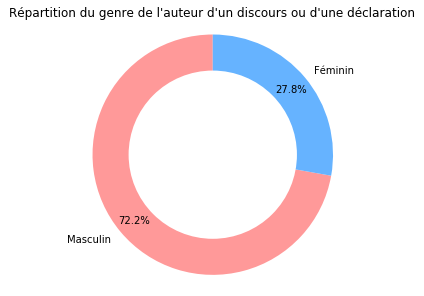

In [15]:
labels = ['Masculin','Féminin']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
sizes = [ 361/500,139/500]
fig, ax1 = plt.subplots()
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Répartition du genre de l'auteur d'un discours ou d'une déclaration")
plt.show()

In [31]:
df['Annee']= df.Date.map(str).apply(lambda x:x[:4])


In [42]:
lst=[]
for an in df.Annee.unique():
    for s in df.sexe.unique():
        if s == 1:
            sexe= 'Masculin'
        else:
            sexe='Féminin'
        lst+=[(an,len(df[(df.Annee == an) & (df.sexe == s)]),sexe)]
data = pd.DataFrame(lst,columns=['Annee','Nb','Sexe'])

Text(0.5, 1.0, "Evolution du nombre d'élocutions par sexe de 1980 à aujourd'hui")

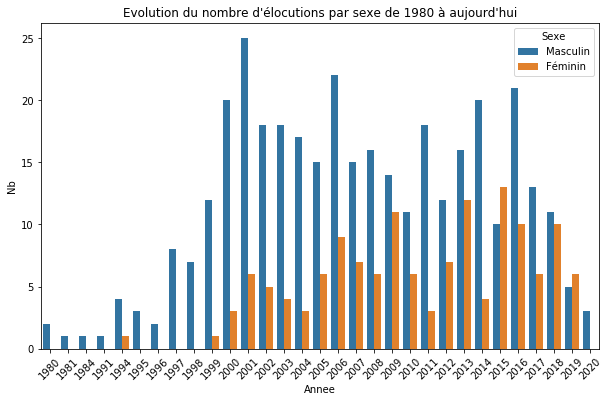

In [48]:
plt.figure(figsize=(10,6))
sns.barplot(data = data,
            x='Annee',
            y='Nb',
           hue='Sexe')
plt.xticks(rotation = 45)
plt.title("Evolution du nombre d'élocutions par sexe de 1980 à aujourd'hui")

In [97]:
df.Tags.fillna('',inplace=True)
arr =df[df.sexe == 2].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_f = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_f.columns=['Themes', 'occurences']
d_f['sexe'] = 'Féminin'
arr =df[df.sexe == 1].Tags.apply(lambda x: str(x).split(',')).array
arr = reduce(add,arr)
c = Counter(arr)
d_m = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d_m.columns=['Themes', 'occurences']
d_m['sexe'] = 'Masculin'
d = pd.concat([d_f,d_m])

In [101]:
print(d_f.occurences.sum(),d_m.occurences.sum())

298 755


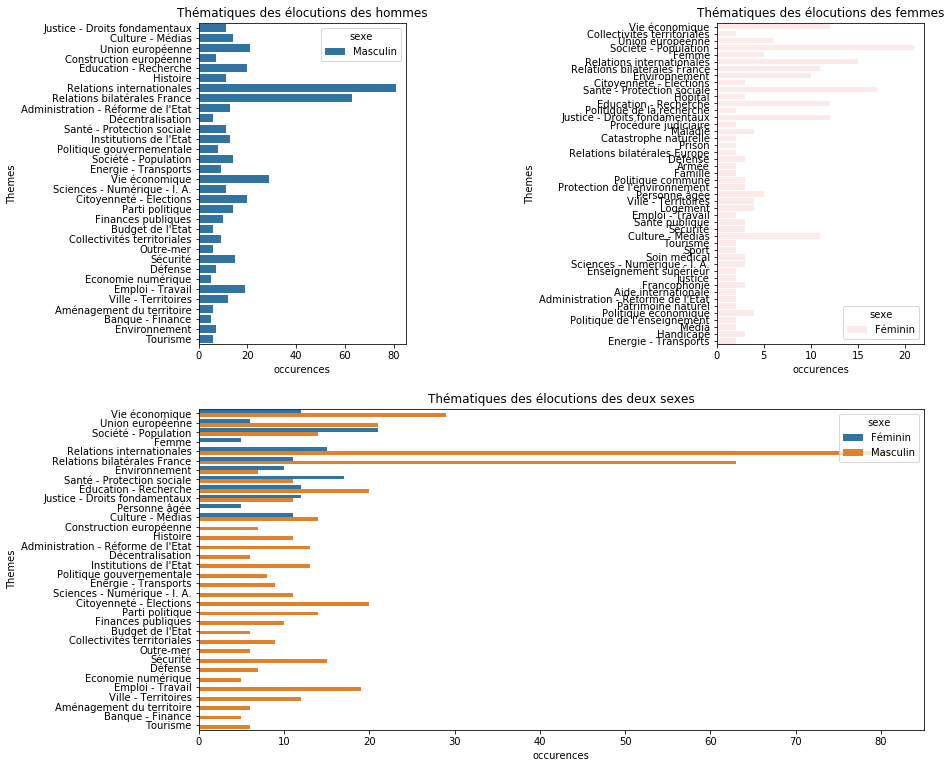

In [122]:
plt.figure(figsize=(13,13))
plt.subplot(221)
sns.barplot(data = d[(d.occurences >= 5) & (d.Themes.apply(len) >0) & (d.sexe == 'Masculin')],
            y='Themes',
            x='occurences',
           hue='sexe')
plt.title("Thématiques des élocutions des hommes")
plt.subplot(222)
sns.barplot(data = d[(d.occurences >= 2) & (d.Themes.apply(len) >0) & (d.sexe == 'Féminin')],
            y='Themes',
            x='occurences',
           hue='sexe',
           color = 'red')
plt.title("Thématiques des élocutions des femmes")
plt.subplot(212)
sns.barplot(data = d[(d.occurences >= 5) & (d.Themes.apply(len) >0)],
            y='Themes',
            x='occurences',
           hue='sexe')
plt.title("Thématiques des élocutions des deux sexes")
plt.subplots_adjust(wspace = 1.5)

In [ ]:
# THEMES

In [ ]:
# FONCTIONS

Désormais nous allons nous concentrer sur le texte uniquement. Pour le faire, nous créeons dans un premier temps un ensemble de fonctions permettant d'étudier le texte.


In [143]:
df.Texte = df.Texte.apply(lambda x:x.replace('\x92',"'"))
df['NbCarac'] = df.Texte.apply(len)

Nous tokenizons notre text pour pouvoir le travailler et sortir d'autres variables par la suite. 
Nous allons tester plusieurs tokenizer pour voir lequel marche le mieux.

Commençons par le tokenizer français de Spacy.

In [128]:
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load('fr_core_news_md')

In [130]:
tokenizer = Tokenizer(nlp.vocab)

In [140]:
print(len([w for w in tokenizer(df.Texte[0])]))

4413


Puis par le tokenizer de nltk

In [129]:
import nltk
from nltk.tokenize import word_tokenize

In [139]:
print(len(word_tokenize(df.Texte[0], language='french')))

4685


Tokenizer basé sur le regex, on remarqu'il ne fonctionne pas bien car tokenize "c'est" en deux "c'" et "est".

In [142]:
from nltk import RegexpTokenizer
toknizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
len(toknizer.tokenize(df.Texte[0]))

5189

On remarque une différence, le tokenizer de nltk tokenize la ponctuation tandis que celui de spacy ne le fait pas visiblement. On va donc utiliser plutôt le tokenizer de nltk.

Pour les stopwords, il semblerait que la liste de spacy soit bien plus complète

In [151]:
len(list(fr_stop)),len(stopwords.words('french'))

(600, 157)

In [177]:
df['NbToken'] = df.Texte.apply(lambda x : len(word_tokenize(x,language='french')))
df['Token'] = df.Texte.apply(lambda x : word_tokenize(x,language='french'))

In [180]:
def cleanToken(x):
    """
        Fonction permettant de nettoyer et de tokenizer un texte
    """
    import string
    pct = string.punctuation+'...'+'\x92'+'«'+'»'+'``'+"''"+'``'
    x = x.replace('\xa0','').replace('\x85','').replace('\x96','')
    x = "".join(filter(lambda y: not y.isdigit(), x))
    sw = list(fr_stop)
    tokens = [str(w).lower() for w in word_tokenize(x, language='french')]
    tokens = [w for w in tokens if w not in pct]
    tokens = [w for w in tokens if w not in sw]
    return tokens

In [ ]:
df['NbCleanToken'] = df.Texte.apply(lambda x : len(cleanToken(x)))
df['CleanToken'] = df.Texte.apply(cleanToken)